DOWNLOAD THE PART OF THE CORPUS \
Repository with all APT notes from 2008 to 2024: https://github.com/aptnotes/data/  # accessed 05.05.2025

tools to download the PDFs:
```py -3.10 -m venv aptnotesvenv                    # apt tools requires older python version
aptnotesvenv\Scripts\Activate.ps1
git clone https://github.com/aptnotes/tools.git  # accessed 05.05.2025
pip install -r .\tools\APTnotes_sync_requirements.txt
pip install lxml --prefer-binary

python tools\APTnotes_sync_download.py

In [ ]:
from PyPDF2 import PdfReader
import fitz
import unicodedata
import os
import re
import json

output_file = 'aptnotes_extracted.jsonl'
working_dir = 'APTnotes'
entries = []

def extract_text_from_pdf(pdf_path, method='PyPDF2'):
    if method == 'PyPDF2':
        doc = PdfReader(pdf_path)
        if doc.is_encrypted:
            print(f"Skipped encrypted PDF: {pdf_path}")
            return []
        pages = doc.pages
    elif method == 'PyMuPDF':
        doc = fitz.open(pdf_path)
        pages = [doc.load_page(i) for i in range(len(doc))]
        doc.close()

    pdf_text = ''
    for i, page in enumerate(pages, start=1):
        page_text_cleaned, page_text = '', ''
        try:
            if method == 'PyPDF2':
                page_text = page.extract_text()
            elif method == 'PyMuPDF':
                page_text = page.get_text()
        except Exception as e:
            print(f"[!] Failed to extract text from page {i} in {pdf_path}: {e}")
            continue
    
        if not page_text:
            continue

        for line in page_text.splitlines():
            if not line.strip():
                continue

            # remove unwanted characters and normalize spaces, skip figure captions, page numbers, and dates footers
            if any([
                re.search(r'^\s*fig.*', line, re.IGNORECASE),
                re.search(r'^\s*table\s*\d+', line, re.IGNORECASE),
                re.search(r'^\s*\d+\s', line),  # same numbers
                re.search(r'^.*page\s*\d+', line, re.IGNORECASE),
                re.search(r'^.*appendix', line, re.IGNORECASE),
                re.search(r'^.*copyright', line, re.IGNORECASE),
                re.search(r'^.*all rights reserved', line, re.IGNORECASE),
                re.search(r'\s{5,}', line),
                re.search(r'(?i)(Vo[l]?\.\s*\d+|Volume\s+\d+|Number\s+\d+|(?:January|February|March|April|May|June|July|August|September|October|November|December)\s+\d{1,2},?\s*\d{4})', line, re.IGNORECASE),
                len(line.split()) < 5  # skip short lines
            ]):
                continue
            line = unicodedata.normalize("NFKC", line)  # normalize unicode characters
            line = re.sub(r'[\x00-\x1F\x7F-\x9F]', '', line)  # remove control and invisible characters
            line = re.sub(r'[^\x00-\x7F]+', ' ', line)  # remove non-ASCII characters
            line = re.sub(r'\.{2,}', ' ', line)  # remove the repeated dots
            line = re.sub(r'(\.\s){2,}', ' ', line)
            line = re.sub(r'\-{2,}', ' ', line)
            line = re.sub(r'\s{2,}', ' ', line)  # remove extra spaces

            page_text_cleaned += line.strip() + ' '

        pdf_text += page_text_cleaned.strip() + ' '

    return pdf_text

used_pdfs = 0
for dir in os.listdir(working_dir):
    file_list = os.listdir(os.path.join(working_dir, dir))
    for file in file_list[:13] + file_list[14:]:  # skip the 14th file in each directory as it causes some errors in the output json file
        if not file.endswith('.pdf'):
            continue

        pdf_path = os.path.join(working_dir, dir, file)
        text = extract_text_from_pdf(pdf_path)
        if text:
            entries.append({"pdf": text})
            used_pdfs += 1

with open(output_file, 'w', encoding='utf-8') as f:
    for entry in entries:
        f.write(json.dumps(entry, ensure_ascii=False) + '\n')

print(f"Used {used_pdfs} PDFs.")
print(f"Max output len: {max(len(entry['pdf']) for entry in entries)}")  # print the max length of the output text

Overwriting cache for 0 1769


Skipped encrypted PDF: APTnotes\2013\Dark_Seoul_Cyberattack.pdf
Skipped encrypted PDF: APTnotes\2013\energy-at-risk.pdf
Skipped encrypted PDF: APTnotes\2014\h12756-wp-shell-crew.pdf
Skipped encrypted PDF: APTnotes\2016\BoozAllen_ukraine-report-when-the-lights-went-out(11-3-2016).pdf
[!] Failed to extract text from page 3 in APTnotes\2016\TheCitizenLab_Between-Hong-Kong-and-Burma_Tracking-UP007-and-SLServer-Espionage-Campaigns(4-18-16).pdf: Odd-length string
[!] Failed to extract text from page 6 in APTnotes\2016\TheCitizenLab_Between-Hong-Kong-and-Burma_Tracking-UP007-and-SLServer-Espionage-Campaigns(4-18-16).pdf: Odd-length string
[!] Failed to extract text from page 9 in APTnotes\2016\TrendMicro_Operation-C-Major_blog(5-18-16).pdf: Odd-length string
Skipped encrypted PDF: APTnotes\2017\ProofPoint_us-wp-north-korea-bitten-by-bitcoin-bug(12-19-2017).pdf
Skipped encrypted PDF: APTnotes\2020\RecordedFuture_pov-2020-1230(12-30-2020).pdf
Skipped encrypted PDF: APTnotes\2022\DrWeb-telecom_r

In [1]:
import json
import re
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("unsloth/tinyllama-bnb-4bit")
max_tokens = 4096

def chunk_text_by_tokens(text):
    sentences = re.split(r'(?<=[.!?])\s+', text.strip())  # devide the text by sentences
    
    chunks = []
    current_chunk = []
    current_len = 0
    
    for sentence in sentences:
        tokens = tokenizer(sentence, add_special_tokens=False)["input_ids"]
        tokenized_len = len(tokens)

        if tokenized_len > max_tokens:
            print(f"Sentence too long ({tokenized_len} tokens), skipping: {sentence[:50]}...")
            continue
        
        tentative_len = current_len + tokenized_len
        if tentative_len <= max_tokens:
            current_chunk.append(sentence)
            current_len = tentative_len
        else:
            if current_chunk:
                chunks.append(' '.join(current_chunk))
            current_chunk = [sentence]
            current_len = tokenized_len
    
    if current_chunk:
        chunks.append(' '.join(current_chunk))
    
    chunks = [chunk.strip() for chunk in chunks if chunk.strip()]
    chunks = [chunk for chunk in chunks if len(chunk.split('.')) > 1]  # remove chunks with only one sentence
    return chunks

input_file = 'aptnotes_extracted.jsonl'     
output_file = 'aptnotes_dataset.jsonl'
output_chunks = []

with open(input_file, 'r', encoding='utf-8') as f:
    for line in f:
        entry = json.loads(line)
        text = entry['pdf']
        chunks = chunk_text_by_tokens(text)
        output_chunks.extend(chunks)

with open(output_file, 'w', encoding='utf-8') as f:
    for chunk in output_chunks:
        f.write(json.dumps({"text": chunk}, ensure_ascii=False) + '\n')

max_len = max(len(tokenizer(chunk, return_tensors="pt", add_special_tokens=False)["input_ids"][0]) for chunk in output_chunks)
print(f"Total chunks created: {len(output_chunks)}")
print(f"Max chunk token length: {max_len}")

Sentence too long (6092 tokens), skipping: [Online] MD5 C&C domain Signed PoisonIvy Profile I...
Sentence too long (4599 tokens), skipping: gicp.net JinDiQIAO@hotmail.com xfish 10012 4e94978...
Sentence too long (11363 tokens), skipping: 0.1 soft@hotmail.com xfish 3460 031bfe6310e55cf37b...
Sentence too long (6609 tokens), skipping: \ ro ot \ Sec ur ity Cent er2 Select * from CIM_Da...
Sentence too long (8799 tokens), skipping: for more information, contact intelreports@kaspers...
Sentence too long (10028 tokens), skipping: Threat family Timestamp MD5 Domain Initial infecto...
Sentence too long (7823 tokens), skipping: (Unnamed UAC Bypasser ) - 212[.]129.13.110 - AutoI...
Sentence too long (6263 tokens), skipping: The most effective protection involves the use of ...
Total chunks created: 1256
Max chunk token length: 4096


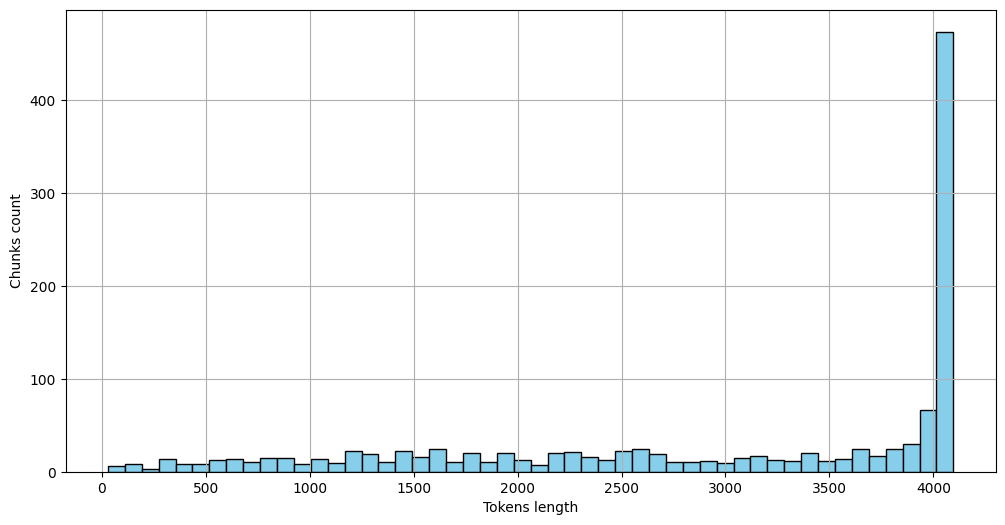

In [2]:
import matplotlib.pyplot as plt

lengths = [len(tokenizer(chunk, add_special_tokens=False)["input_ids"]) for chunk in output_chunks]

plt.figure(figsize=(12,6))
plt.hist(lengths, bins=50, color='skyblue', edgecolor='black')
# plt.title("Distribution of chunk lengths")
plt.xlabel("Tokens length")
plt.ylabel("Chunks count")
plt.grid(True)
plt.savefig('aptnotes_chunk_length_distribution.svg')
plt.show()